<a href="https://colab.research.google.com/github/jjAguil/Tareas-Simulacion/blob/main/Tarea_mc_acciones_ibex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternativa
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf

In [54]:
RISKY_ASSET = 'IBEX'
START_DATE = '2020-01-01'
END_DATE = '2022-06-01'

In [15]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Descargados {df.shape[0]} renglones de datos.')

[*********************100%***********************]  1 of 1 completed
Descargados 353 renglones de datos.


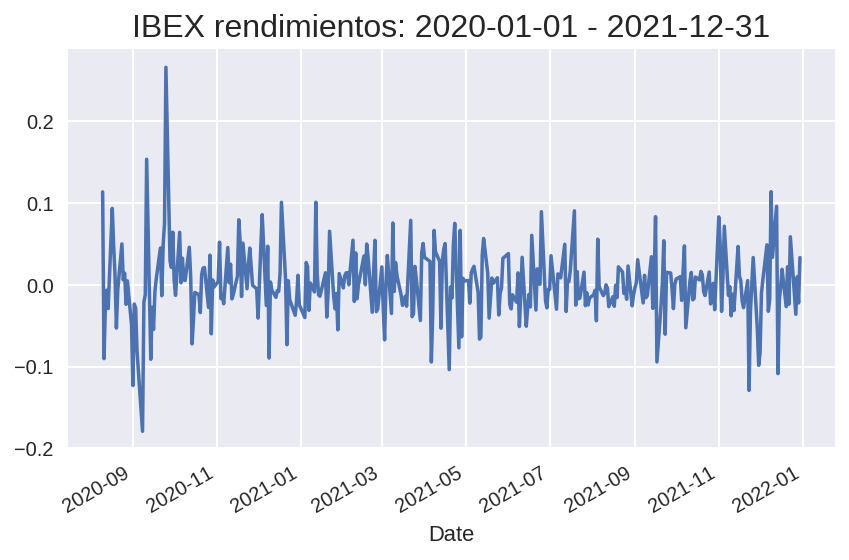

Rendimiento promedio: 0.06%


In [16]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()   

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} rendimientos: {START_DATE} - {END_DATE}', 
             fontsize=16)


plt.tight_layout()
#plt.savefig('imagen1.png')
plt.show()

print(f'Rendimiento promedio: {100 * returns.mean():.2f}%')

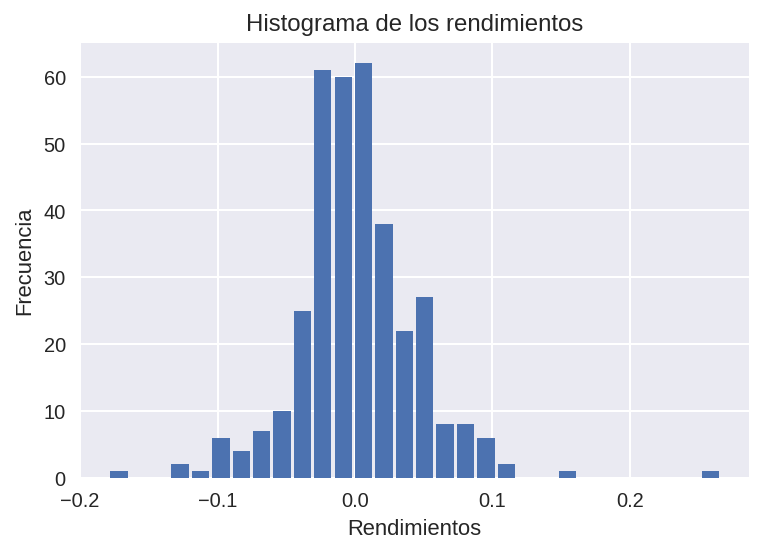

In [17]:
plt.hist(x=returns, rwidth=0.85, bins=30)
plt.title('Histograma de los rendimientos')
plt.xlabel('Rendimientos')
plt.ylabel('Frecuencia')

plt.show()

PRIMER INTERVALO

In [18]:
train = returns['2020-01-01':'2020-12-31']
test = returns['2021-01-01':'2021-06-01']

In [19]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

In [20]:
from scipy import stats

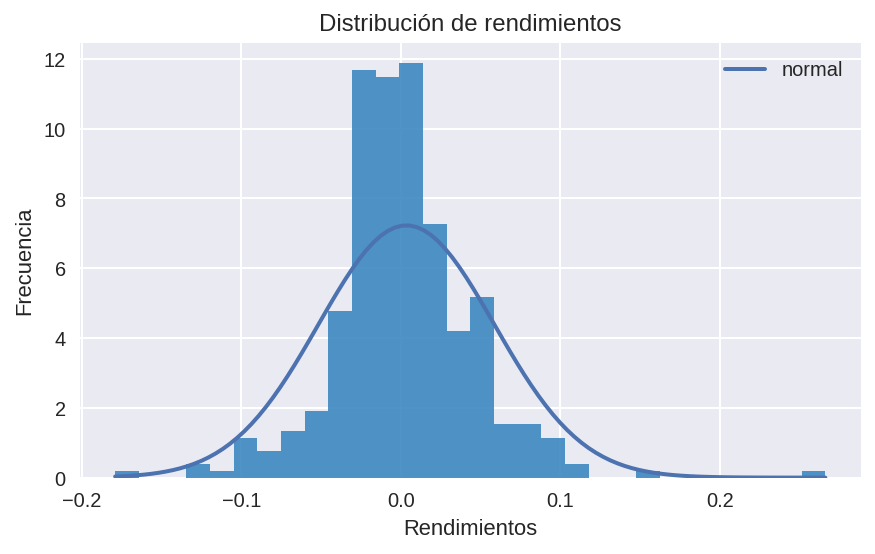

In [21]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

In [25]:
import pylab 
from scipy.stats import kstest
from scipy import stats

In [23]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):

    np.random.seed(random_seed)
    
    # incremento de tiempo
    dt = T/N
    
    # Movimiento Browniano con variables antiteticas
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # evolucion del proceso
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [26]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

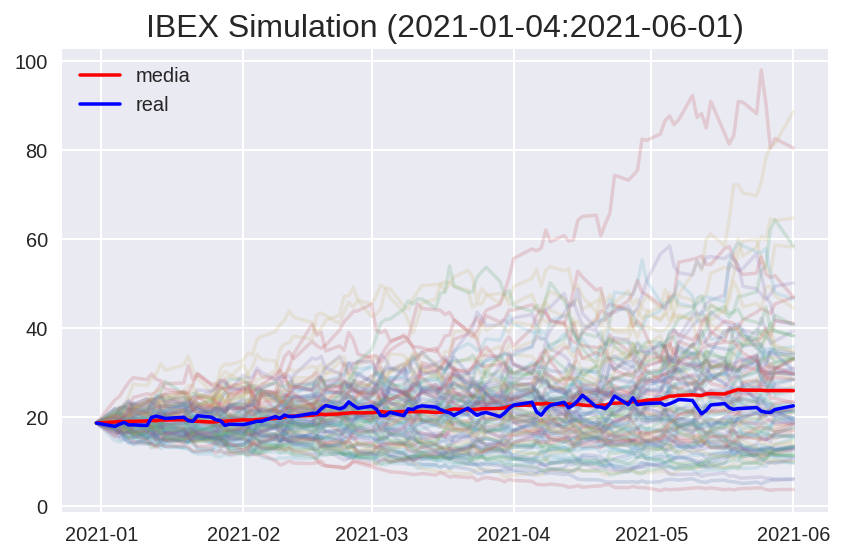

In [27]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

SEGUNDO INTERVALO

In [96]:
train = returns['2021-01-01':'2021-08-01']
test = returns['2021-08-02':'2021-12-31']

In [97]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 3000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

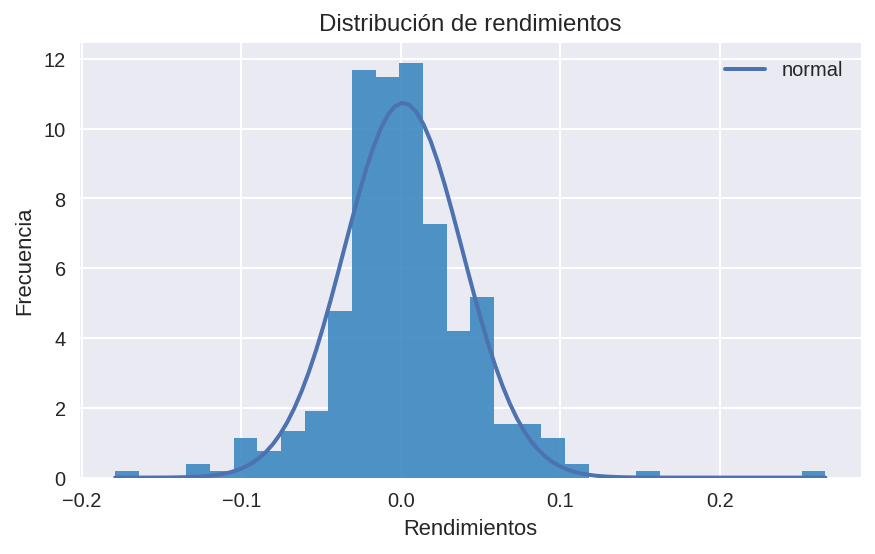

In [98]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

In [99]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=144, antithetic_var=False):

    np.random.seed(random_seed)
    
    # incremento de tiempo
    dt = T/N
    
    # Movimiento Browniano con variables antiteticas
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # evolucion del proceso
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [100]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

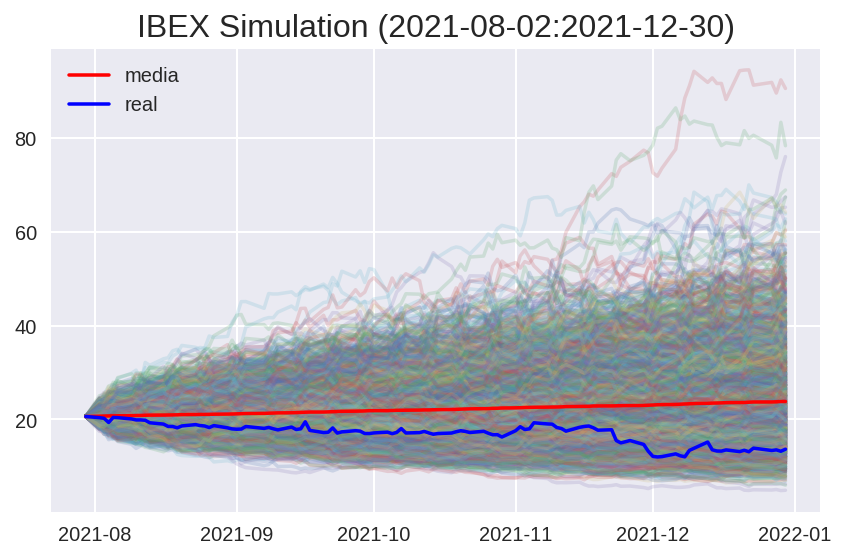

In [101]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

SE REALIZO CON VARIABLES ANTITETICAS Y 1000 EXPERIMENTOS Y NI AUN ASI SE TUVO UNA BUENA APROXIMACION, LO QUE QUIERE DECIR QUE LAS ACCIONES EN ESE INTERVALO FUERON POCO PREDECIBLES SEGURAMENTE POR RIESGOS SISTEMATICOS

TERCER INTERVALO

In [86]:
train = returns['2020-01-01':'2021-08-31']
test = returns['2021-09-01':'2021-12-31']

In [91]:
T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 1000

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

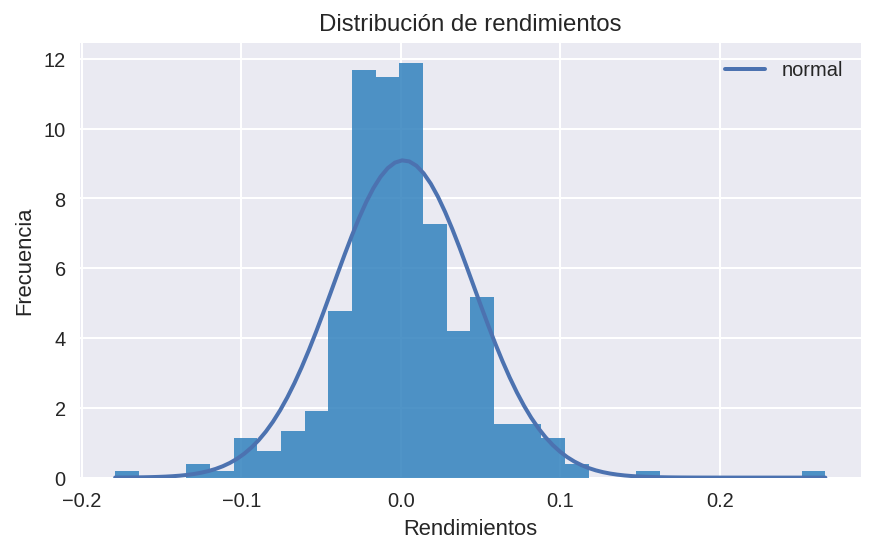

In [88]:
x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

In [92]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=44, antithetic_var=False):

    np.random.seed(random_seed)
    
    # incremento de tiempo
    dt = T/N
    
    # Movimiento Browniano con variables antiteticas
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # evolucion del proceso
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [93]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

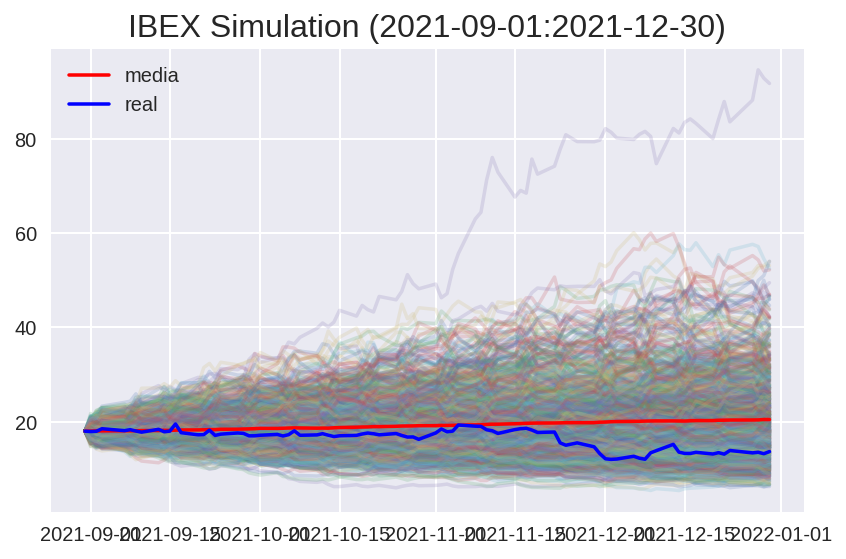

In [95]:
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()